Imports

In [39]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import History
import matplotlib.pyplot as plt
import numpy as np
import gpu_imports


Data Augmentation

In [40]:
batch_size = 32
num_classes = 2
image_size = 64

datagen = ImageDataGenerator(
    rescale = 1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True,
    validation_split=0.1)


In [42]:
train_generator = datagen.flow_from_directory(
    './cell_images',
    target_size = (image_size, image_size),
    batch_size = batch_size,
    class_mode = 'binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    './cell_images',
    target_size = (image_size, image_size),
    batch_size = batch_size,
    class_mode = 'binary',
    subset='validation'
)

Found 24804 images belonging to 2 classes.
Found 2754 images belonging to 2 classes.


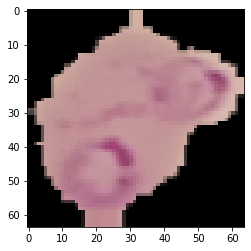

In [43]:
sample = train_generator.next();
plt.imshow(sample[0][0])
train_generator.reset()

Imports for Model

In [44]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers.advanced_activations import ELU

Building Model

In [65]:
model = Sequential()

# 1st Conv Layer
model.add(Conv2D(64, (3, 3), padding = 'same', input_shape=(image_size, image_size, 3)))
model.add(Activation('elu'))
model.add(BatchNormalization())

# 2nd Conv Layer
model.add(Conv2D(64, (3, 3), padding = 'same', input_shape=(image_size, image_size, 3)))
model.add(Activation('elu'))
model.add(BatchNormalization())

# Max Pooling with Dropout
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 3rd Conv Layer
model.add(Conv2D(128,(3,3), padding = 'same'))
model.add(Activation('elu'))
model.add(BatchNormalization())

# 4th Conv Layer
model.add(Conv2D(128,(3,3), padding = 'same'))
model.add(Activation('elu'))
model.add(BatchNormalization())

# Max Pooling with Dropout
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 5th Conv Layer
model.add(Conv2D(256,(3,3), padding = 'same'))
model.add(Activation('elu'))
model.add(BatchNormalization())

# 6th Conv Layer
model.add(Conv2D(256,(3,3), padding = 'same'))
model.add(Activation('elu'))
model.add(BatchNormalization())

# Max Pooling with Dropout
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 1st FC Dense Layer
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# 2nd FC Dense Layer
model.add(Dense(256))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Final Dense Layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
activation_49 (Activation)   (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
activation_50 (Activation)   (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 32, 32, 64)      

What the model looks like

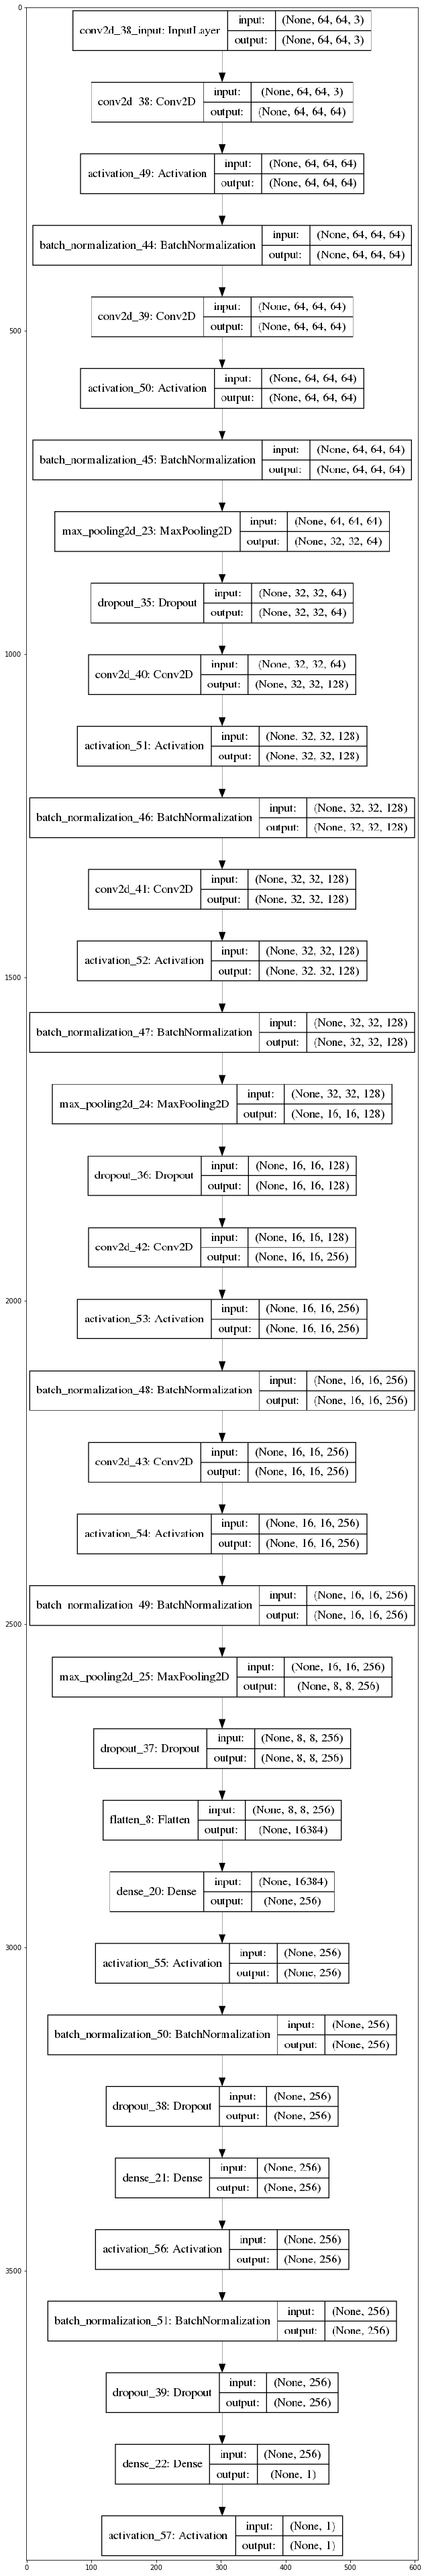

In [66]:
%matplotlib inline
import keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

plot_model(model, to_file='ModifiedVGG.png', show_shapes = True, show_layer_names = True)
img = mpimg.imread('ModifiedVGG.png')
plt.figure(figsize = (100,70))
imgplot = plt.imshow(img)

Early stopping, checkpointing and Reducing Learning Rate on Plateau

In [69]:
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('./Saved_Model/MalariaModifiedVGG.h5',
                            monitor = 'val_loss',
                            mode = 'min',
                            save_best_only = True,
                            verbose = 1)

earlystop = EarlyStopping(monitor = 'val_loss',
                         min_delta = 0,
                         patience = 15,
                         verbose = 1,
                         restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                             factor = 0.01,
                             patience = 15,
                             verbose = 1,
                             min_delta = 0.00001)

callbacks = [checkpoint, earlystop, reduce_lr]

model.compile(loss = 'binary_crossentropy',
             optimizer = Adam(lr=0.001, decay = 0.001 / 64),
             metrics = ['accuracy'])



In [70]:
epochs = 100
nb_train_samples = 5000
nb_test_samples = 2000

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_test_samples // batch_size)

Epoch 1/100
156/156 [==============================] - 79s 508ms/step - loss: 0.1936 - accuracy: 0.9393 - val_loss: 0.1413 - val_accuracy: 0.9274

Epoch 00001: val_loss improved from inf to 0.14129, saving model to ./Saved_Model/MalariaModifiedVGG.h5
Epoch 2/100
156/156 [==============================] - 76s 489ms/step - loss: 0.1759 - accuracy: 0.9460 - val_loss: 0.2527 - val_accuracy: 0.9232

Epoch 00002: val_loss did not improve from 0.14129
Epoch 3/100
156/156 [==============================] - 64s 412ms/step - loss: 0.1638 - accuracy: 0.9503 - val_loss: 0.2270 - val_accuracy: 0.9069

Epoch 00003: val_loss did not improve from 0.14129
Epoch 4/100
156/156 [==============================] - 60s 385ms/step - loss: 0.1491 - accuracy: 0.9537 - val_loss: 0.0343 - val_accuracy: 0.9224

Epoch 00004: val_loss improved from 0.14129 to 0.03432, saving model to ./Saved_Model/MalariaModifiedVGG.h5
Epoch 5/100
156/156 [==============================] - 77s 493ms/step - loss: 0.1478 - accuracy: 0